In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define transforms (normalize as per ResNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load training dataset (reconstructed images)
train_dataset = datasets.ImageFolder(root="/kaggle/input/exp-2-ee6180/recon_dataset", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Load evaluation dataset (original images)
test_dataset = datasets.ImageFolder(root="/kaggle/input/imagenet100/train.X1", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load ResNet Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False, num_classes=len(train_dataset.classes)).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
def train_model(model, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

from sklearn.metrics import precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

# Enhanced Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Predicted labels (for accuracy & F1-score)
            _, predicted = torch.max(outputs, 1)
            
            # Get softmax probabilities for PR curve
            probs = F.softmax(outputs, dim=1)
            max_probs, _ = torch.max(probs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(max_probs.cpu().numpy())

    # Compute Accuracy
    correct = sum(np.array(all_labels) == np.array(all_preds))
    total = len(all_labels)
    acc = 100 * correct / total
    print(f"Classification Accuracy Score (CAS): {acc:.2f}%")

    # Classification Report (Precision, Recall, F1-score)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    # # Precision-Recall Curve for each class
    # plt.figure(figsize=(8, 6))
    # for class_id in range(num_classes):
    #     precision, recall, _ = precision_recall_curve(
    #         (all_labels == class_id).astype(int), all_probs[:, class_id]
    #     )
    #     plt.plot(recall, precision, marker='.', label=f'Class {class_id}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [2]:
# # Train and Evaluate
# train_model(model, train_loader, epochs=10)

Epoch 1, Loss: 2.3325381684960345
Epoch 2, Loss: 1.5894026627808104
Epoch 3, Loss: 1.1860461785333363
Epoch 4, Loss: 0.9155416944482195
Epoch 5, Loss: 0.680885093418632
Epoch 6, Loss: 0.4770627333159287
Epoch 7, Loss: 0.3170808983607379
Epoch 8, Loss: 0.20646912967749526
Epoch 9, Loss: 0.16028590229207898
Epoch 10, Loss: 0.11139935950609291


In [3]:
# ss = model.state_dict()
# torch.save(ss,'model.pt')

In [4]:
# evaluate_model(model, test_loader)

100%|██████████| 1016/1016 [01:57<00:00,  8.61it/s]

Classification Accuracy Score (CAS): 70.55%

Classification Report:
              precision    recall  f1-score   support

           0     0.9472    0.7454    0.8343      1300
           1     0.8992    0.6108    0.7274      1300
           2     0.7662    0.6731    0.7166      1300
           3     0.7181    0.9662    0.8239      1300
           4     0.8248    0.7931    0.8086      1300
           5     0.8821    0.1900    0.3127      1300
           6     0.7426    0.6569    0.6971      1300
           7     0.7002    0.6631    0.6812      1300
           8     0.5130    0.8931    0.6517      1300
           9     0.8434    0.5923    0.6959      1300
          10     0.8216    0.8292    0.8254      1300
          11     0.6374    0.8992    0.7460      1300
          12     0.7399    0.9538    0.8333      1300
          13     0.6650    0.8338    0.7399      1300
          14     0.7001    0.7577    0.7277      1300
          15     0.8004    0.6538    0.7197      1300
          16 

In [4]:
print(device)

cuda


In [5]:
model.load_state_dict(torch.load('/kaggle/input/vqvae_precision_recall_model/pytorch/default/1/model.pt', map_location=device))
model.to(device)
model.eval()

<ipython-input-5-7a715e9ffd4c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/vqvae_precision_recall_model/pytorch/default/

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from scipy.interpolate import interp1d

In [15]:
def plot_average_pr_curve(model, dataloader, num_classes, device):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Get class probabilities

            y_true.extend(labels.cpu().numpy())  # True labels
            y_scores.extend(probs.cpu().numpy())  # Predicted probabilities

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Compute PR curve for each class
    all_precisions = []
    all_recalls = np.linspace(0, 1, 20)  # Standard recall range for interpolation

    for class_idx in range(num_classes):
        binary_labels = (y_true == class_idx).astype(int)
        precision, recall, _ = precision_recall_curve(binary_labels, y_scores[:, class_idx])
        
        # Interpolate precision values to align with a common recall scale
        interp_func = interp1d(recall, precision, kind='linear', fill_value="extrapolate")
        interpolated_precision = interp_func(all_recalls)
        all_precisions.append(interpolated_precision)

    # Compute mean precision at each recall level
    mean_precision = np.mean(all_precisions, axis=0)
    pr_auc = auc(all_recalls, mean_precision)  # Compute AUC for averaged PR curve

    # Plot Average PR Curve
    plt.figure(figsize=(8, 6))
    plt.plot(all_recalls, mean_precision, color='blue', lw=2, label=f'Average PR Curve (AUC={pr_auc:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Average Precision-Recall Curve for Multi-Class Classification")
    plt.legend()
    plt.grid()
    plt.show()
    return all_recalls, mean_precision


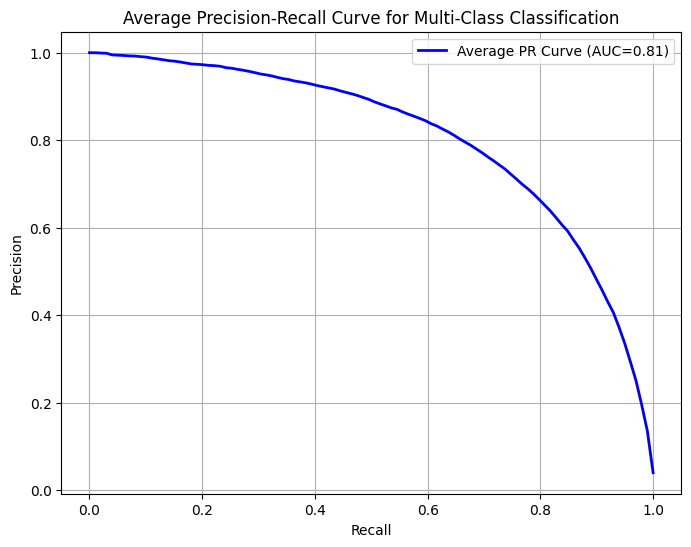

In [11]:
plot_average_pr_curve(model, test_loader, num_classes = 25, device = "cuda")




In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained ResNet and Modify Final Layer
def get_resnet_model(num_classes=25):
    model = models.resnet50(pretrained=True)  # Load Pretrained ResNet-50
    in_features = model.fc.in_features  # Get input size of last layer
    model.fc = nn.Linear(in_features, num_classes)  # Modify FC layer for 25 classes
    return model

# Define Transforms for Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Training Data
train_dataset = datasets.ImageFolder(root="/kaggle/input/exp-2-ee6180/recon_dataset", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize Model
model2 = get_resnet_model(num_classes=25).to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.0001)  # Use Adam optimizer

# Fine-Tune for 5 Epochs
num_epochs = 5
for epoch in range(num_epochs):
    model2.train()  # Set to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero gradients
        outputs = model2(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Fine-tuning complete!")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s]


Epoch [1/5], Loss: 0.3240
Epoch [2/5], Loss: 0.1111
Epoch [3/5], Loss: 0.0779
Epoch [4/5], Loss: 0.0678
Epoch [5/5], Loss: 0.0543
Fine-tuning complete!


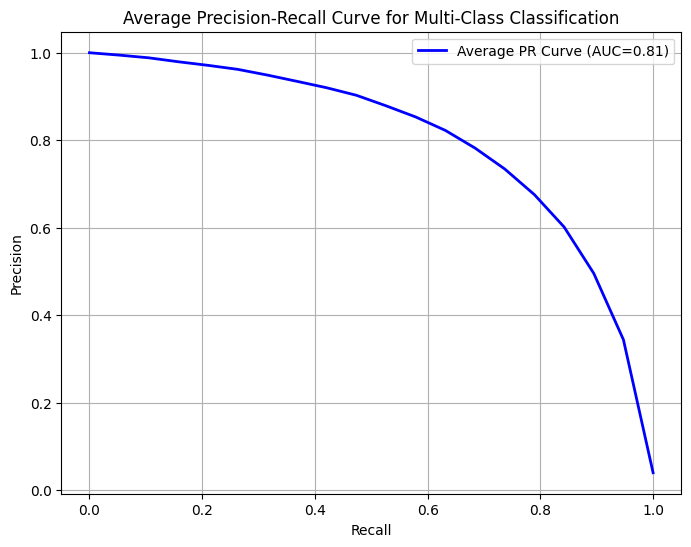

In [16]:
r1, p1 =  plot_average_pr_curve(model, test_loader, num_classes = 25, device = "cuda")


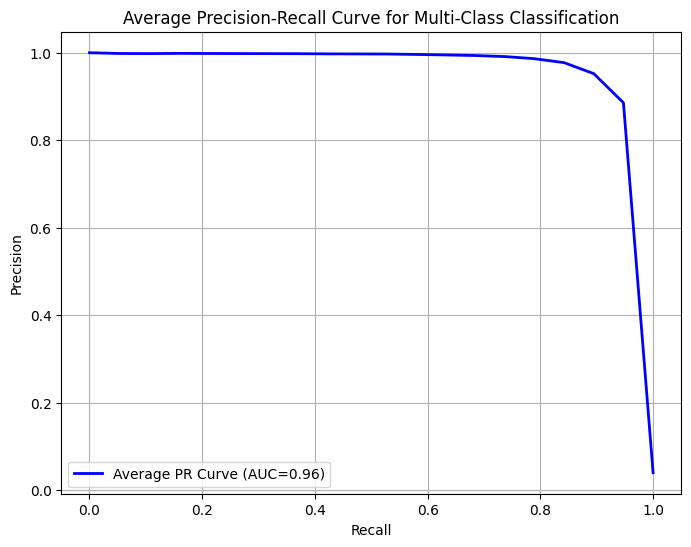

In [17]:
r2, p2 = plot_average_pr_curve(model2, test_loader, num_classes = 25, device = "cuda")

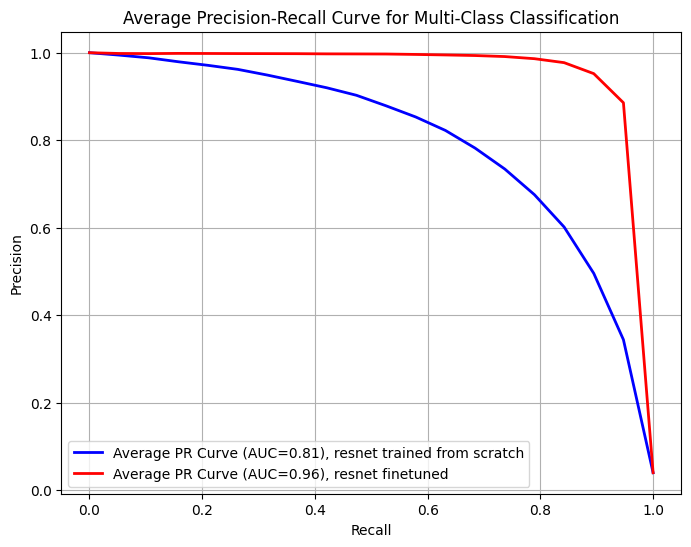

In [19]:
    # Plot Average PR Curve
plt.figure(figsize=(8, 6))
plt.plot(r1, p1, color='blue', lw=2, label=f'Average PR Curve (AUC=0.81), resnet trained from scratch')
plt.plot(r2, p2, color= 'red', lw =2, label = f'Average PR Curve (AUC=0.96), resnet finetuned')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Average Precision-Recall Curve for Multi-Class Classification")
plt.legend()
plt.grid()
plt.show()

In [21]:
evaluate_model(model, test_loader)

  0%|          | 5/1016 [00:00<02:21,  7.14it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78295da5f130>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  3%|▎         | 30/1016 [00:03<01:15, 13.12it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78295da5f130>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/

Classification Accuracy Score (CAS): 70.55%

Classification Report:
              precision    recall  f1-score   support

           0     0.9472    0.7454    0.8343      1300
           1     0.8992    0.6108    0.7274      1300
           2     0.7662    0.6731    0.7166      1300
           3     0.7181    0.9662    0.8239      1300
           4     0.8248    0.7931    0.8086      1300
           5     0.8821    0.1900    0.3127      1300
           6     0.7426    0.6569    0.6971      1300
           7     0.7002    0.6631    0.6812      1300
           8     0.5130    0.8931    0.6517      1300
           9     0.8434    0.5923    0.6959      1300
          10     0.8216    0.8292    0.8254      1300
          11     0.6374    0.8992    0.7460      1300
          12     0.7399    0.9538    0.8333      1300
          13     0.6650    0.8338    0.7399      1300
          14     0.7001    0.7577    0.7277      1300
          15     0.8004    0.6538    0.7197      1300
          16 

In [22]:
evaluate_model(model2, test_loader)

100%|██████████| 1016/1016 [01:33<00:00, 10.90it/s]

Classification Accuracy Score (CAS): 90.78%

Classification Report:
              precision    recall  f1-score   support

           0     0.9933    0.9138    0.9519      1300
           1     0.9749    0.9246    0.9491      1300
           2     0.9537    0.9185    0.9357      1300
           3     0.9983    0.9200    0.9576      1300
           4     0.9937    0.8454    0.9135      1300
           5     0.9159    0.8885    0.9020      1300
           6     0.9829    0.6631    0.7919      1300
           7     0.6229    0.9962    0.7665      1300
           8     0.9427    0.9615    0.9520      1300
           9     0.9165    0.9623    0.9388      1300
          10     0.9869    0.9285    0.9568      1300
          11     0.9796    0.8854    0.9301      1300
          12     0.9830    0.9323    0.9570      1300
          13     0.9740    0.9492    0.9614      1300
          14     0.9081    0.9654    0.9359      1300
          15     0.9616    0.9046    0.9322      1300
          16 

In [26]:
pip install pytorch_fid

Note: you may need to restart the kernel to use updated packages.


In [27]:
import torch
import os
from pytorch_fid import fid_score
from torchmetrics.image.inception import InceptionScore
from torchvision import transforms
from PIL import Image
import tempfile

In [34]:
#compute fid is
real_images_root = "/kaggle/input/imagenet100/train.X1"  # Parent folder with 25 class folders
generated_images_root = "/kaggle/input/exp-2-ee6180/recon_dataset"  # Parent folder with 25 class folders



In [38]:
import shutil
# Image transform for Inception model
transform = transforms.Compose([
    transforms.Resize((299, 299)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def count_images_in_folder(root_folder):
    """Counts the number of image files in a given folder and its subfolders."""
    count = 0
    for subdir in os.listdir(root_folder):
        subdir_path = os.path.join(root_folder, subdir)
        if os.path.isdir(subdir_path):
            count += sum(1 for img in os.listdir(subdir_path) if img.lower().endswith((".png", ".jpg", ".jpeg")))
    return count

# Count images in real and generated datasets
num_real_images = count_images_in_folder(real_images_root)
num_generated_images = count_images_in_folder(generated_images_root)

# Create temporary folders for merged datasets
with tempfile.TemporaryDirectory() as real_combined, tempfile.TemporaryDirectory() as gen_combined:
    
    # Copy all real images to one folder
    for class_folder in os.listdir(real_images_root):
        class_path = os.path.join(real_images_root, class_folder)
        if os.path.isdir(class_path):
            for img in os.listdir(class_path):
                if img.lower().endswith((".png", ".jpg", ".jpeg")):
                    shutil.copy(os.path.join(class_path, img), os.path.join(real_combined, img))

    # Copy all generated images to one folder
    for class_folder in os.listdir(generated_images_root):
        class_path = os.path.join(generated_images_root, class_folder)
        if os.path.isdir(class_path):
            for img in os.listdir(class_path):
                if img.lower().endswith((".png", ".jpg", ".jpeg")):
                    shutil.copy(os.path.join(class_path, img), os.path.join(gen_combined, img))

    batch_size = min(50, num_real_images, num_generated_images)
    # Compute combined FID
    fid_value = fid_score.calculate_fid_given_paths(
        paths=[real_combined, gen_combined], 
        batch_size=50, 
        device=device,
        dims=2048  
    )

# Compute combined Inception Score (IS)
def compute_inception_score(images_root):
    inception = InceptionScore(normalize=True).to(device)
    image_tensors = []
    
    for img_name in os.listdir(images_root):
        img_path = os.path.join(images_root, img_name)
        if img_path.lower().endswith((".png", ".jpg", ".jpeg")):
            img = Image.open(img_path).convert("RGB")
            img = transform(img)
            image_tensors.append(img)

    if len(image_tensors) == 0:
        return None, None  # No images found

    images = torch.stack(image_tensors).to(device)
    is_score = inception(images)

    return is_score.mean().item(), is_score.std().item()

# Compute IS using all generated images
is_mean, is_std = compute_inception_score(generated_images_root)

# Print results
print(f"\n📊 **Final Metrics Across All Classes**:")
print(f"🔹 **FID Score:** {fid_value:.2f}")
print(f"🔹 **Inception Score:** {is_mean:.2f} ± {is_std:.2f}")


ValueError: batch_size should be a positive integer value, but got batch_size=0